# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Configurations

In [2]:
IMG_SIZE=256
LABELS=["0","1","2"]
NO_OF_CLASSES = len(LABELS)
BATCH_SIZE=32

# Dataset

## Download the dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6M6TEU/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6M6TEU/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpzl6kyjb6tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [5]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

## Create tf dataset
While creating the dataset all fields except 'image' and 'segmentation_mask' are discarded. Then both of them are resized and typecasted to uint8

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((
    [tf.cast(tf.image.resize(item['image'], (IMG_SIZE, IMG_SIZE)),tf.uint8) for item in list(dataset['train'])],
    [tf.cast(tf.image.resize(item['segmentation_mask'], (IMG_SIZE, IMG_SIZE)),tf.uint8) for item in list(dataset['train'])]
    ))

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [7]:
# Create a TensorFlow dataset from the extracted images and masks
test_ds = tf.data.Dataset.from_tensor_slices((
    [tf.cast(tf.image.resize(item['image'], (IMG_SIZE, IMG_SIZE)),tf.uint8) for item in list(dataset['test'])],
    [tf.cast(tf.image.resize(item['segmentation_mask'], (IMG_SIZE, IMG_SIZE)),tf.uint8) for item in list(dataset['test'])]
    ))

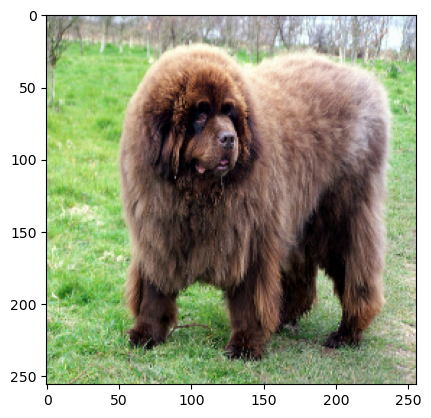

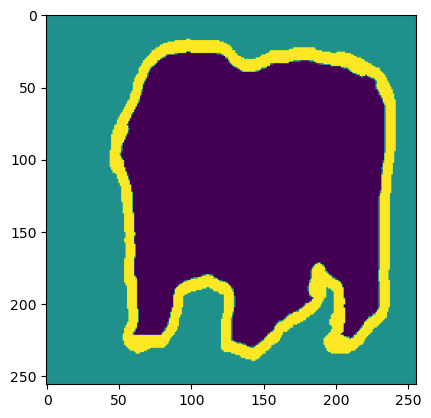

In [8]:
# Print an examples from the dataset
for image, mask in train_ds.skip(6).take(1):
    plt.imshow(image)
    plt.show()
    plt.imshow(mask)
    plt.show()

## Input data pipeline
The labels in the segmentation mask are any integer in [1,2,3]. First the labels are converted to [0,1,2] by subtracting 1, then one hot encoded and then batched.

In [9]:
train_ds_processed = train_ds.map(lambda x,y:(x,y-1)).map(lambda u,v:(u,tf.one_hot(tf.squeeze(v),depth=NO_OF_CLASSES))).batch(BATCH_SIZE)
test_ds_processed = test_ds.map(lambda x,y:(x,y-1)).map(lambda u,v:(u,tf.one_hot(tf.squeeze(v),depth=NO_OF_CLASSES))).batch(BATCH_SIZE)

In [10]:
# Print a few examples from the dataset
for image, mask in test_ds_processed.skip(6).take(1):
    print(image.shape)
    print(mask.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)


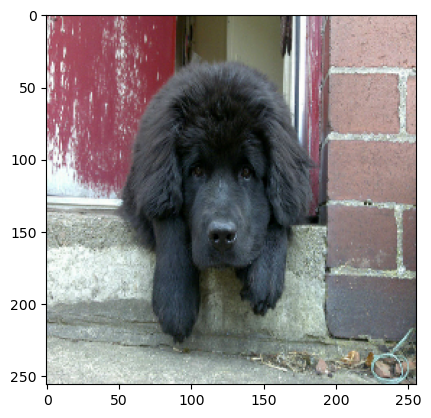

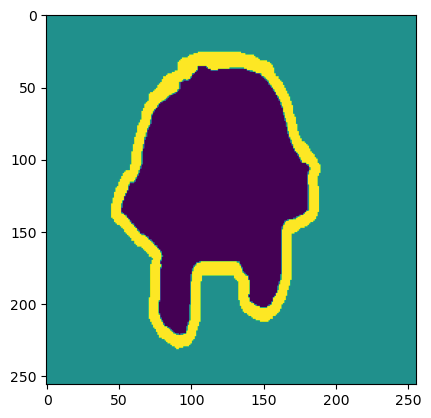

tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)


In [11]:
for image, mask in test_ds.skip(6).take(1):
    plt.imshow(image)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(mask[125,125])
    print(mask[1,1])

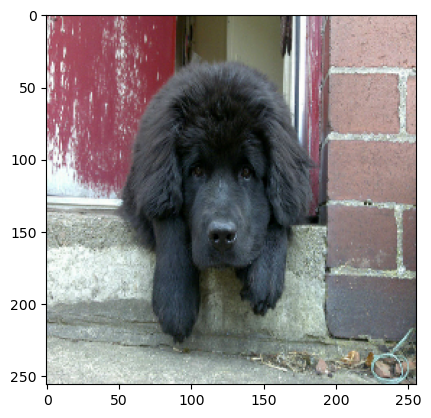

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


In [12]:
for image_batch, mask_batch in test_ds_processed.take(1):
    plt.imshow(image_batch[6])
    plt.show()
    print(mask_batch[6][125,125])
    print(mask_batch[6][1,1])

# Define the model
https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

In [13]:
def build_model(input_shape, no_of_classes, start_neurons):
    input_layer = tf.keras.layers.Input(input_shape)
    
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.25)(pool1)

    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.5)(pool2)

    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.5)(pool3)

    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.5)(pool4)

    # Middle
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(0.5)(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(0.5)(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
    uconv2 = tf.keras.layers.Dropout(0.5)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = tf.keras.layers.Conv2D(no_of_classes, (1,1), padding="same", activation="softmax")(uconv1)
    
    model = keras.Model(input_layer, output_layer)
    
    return model


model = build_model(input_shape = (IMG_SIZE, IMG_SIZE, 3), no_of_classes = NO_OF_CLASSES , start_neurons = 16)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

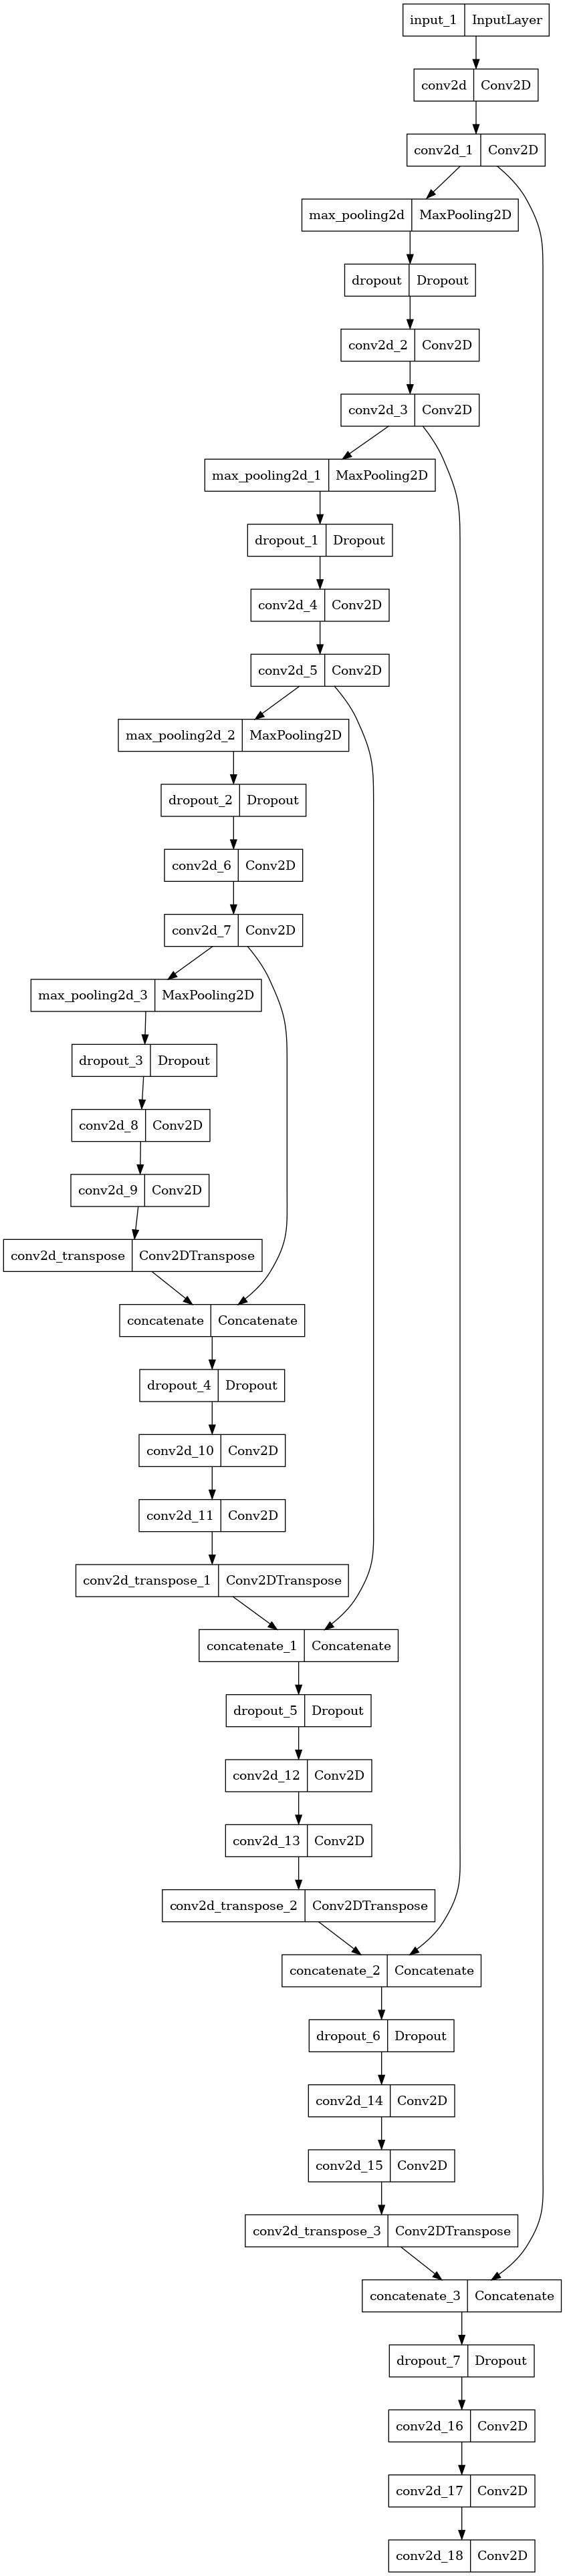

In [15]:
tf.keras.utils.plot_model(model)

# Train the model

In [17]:
del train_ds
del test_ds

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.01,
    restore_best_weights = True,
    verbose = 1
)

In [20]:
EPOCHS = 100

In [21]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)


history = model.fit(
    train_ds_processed, 
    epochs=EPOCHS, 
    validation_data=test_ds_processed,
    callbacks=[early_stopping]
)

Epoch 1/100


2023-06-28 11:50:47.769345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


115/115 [==============================] - 49s 269ms/step - loss: 1.0196 - accuracy: 0.5811 - val_loss: 0.8380 - val_accuracy: 0.5856
Epoch 2/100
115/115 [==============================] - 29s 251ms/step - loss: 0.7730 - accuracy: 0.6478 - val_loss: 0.7400 - val_accuracy: 0.7156
Epoch 3/100
115/115 [==============================] - 29s 251ms/step - loss: 0.6889 - accuracy: 0.7307 - val_loss: 0.6478 - val_accuracy: 0.7466
Epoch 4/100
115/115 [==============================] - 29s 251ms/step - loss: 0.6267 - accuracy: 0.7582 - val_loss: 0.5832 - val_accuracy: 0.7742
Epoch 5/100
115/115 [==============================] - 29s 251ms/step - loss: 0.5737 - accuracy: 0.7800 - val_loss: 0.5272 - val_accuracy: 0.7963
Epoch 6/100
115/115 [==============================] - 29s 251ms/step - loss: 0.5535 - accuracy: 0.7887 - val_loss: 0.5276 - val_accuracy: 0.7959
Epoch 7/100
115/115 [==============================] - 29s 252ms/step - loss: 0.5276 - accuracy: 0.7985 - val_loss: 0.4823 - val_accurac

In [22]:
model.save("model")
!zip -r model.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/assets/ (stored 0%)
  adding: kaggle/working/model/fingerprint.pb (stored 0%)
  adding: kaggle/working/model/saved_model.pb (deflated 90%)
  adding: kaggle/working/model/variables/ (stored 0%)
  adding: kaggle/working/model/variables/variables.index (deflated 73%)
  adding: kaggle/working/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/model/keras_metadata.pb (deflated 95%)


# Run inference

## Inference on an image in test_dataset

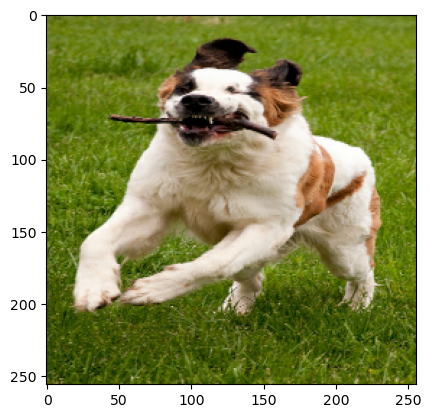

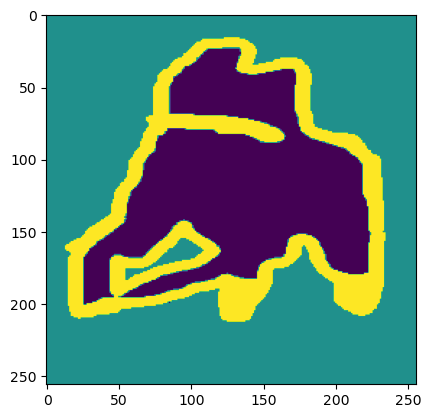

1/1 [==============================] - 0s 20ms/step


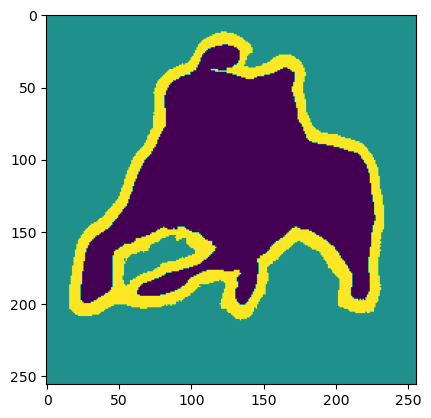

In [34]:
for image_batch,mask_batch in test_ds_processed.take(1):
    i=2
    plt.imshow(image_batch[i])
    plt.show()
    plt.imshow(np.argmax(mask_batch[i],axis=2))
    plt.show()
    plt.imshow(np.argmax(model.predict(image_batch[i:i+1])[0],axis=2))
    plt.show()

## Inference on new image

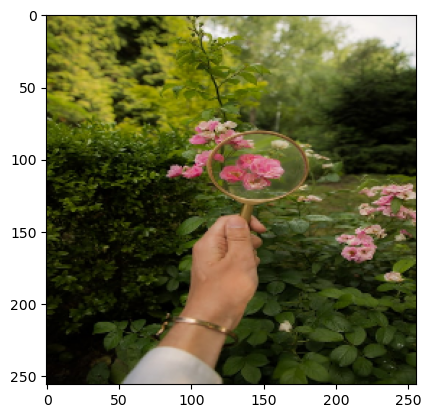

1/1 [==============================] - 0s 21ms/step


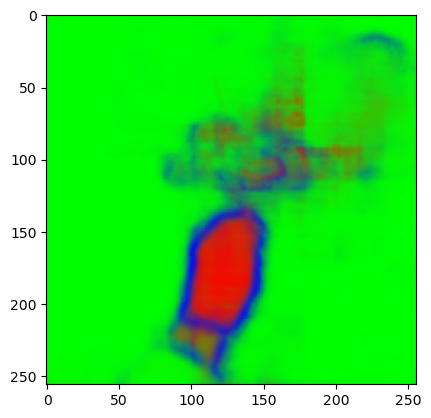

In [51]:
# Load the image from a URL
import cv2
import urllib
import numpy as np

URL="https://images.unsplash.com/photo-1687273195751-14befe467d43?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxlZGl0b3JpYWwtZmVlZHwzNnx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=500&q=60"
req = urllib.request.urlopen(URL)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'
img =  cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(256,256))
plt.imshow(img)
plt.show()



# Run prediction
mask = model.predict(np.expand_dims(img,0))[0]
plt.imshow(mask)
plt.show()